<a href="https://colab.research.google.com/github/moe18/Appels-V.S.-Peaches/blob/master/Appels_VS_Peaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appels and Oranges

- Built a classifier that trys and determin if a picture is of a apple tree or a orange tree.
- got the data from the flickr API


In [0]:
%matplotlib inline

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenetv2 import MobileNetV2
from keras import applications
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input

from scipy import ndimage
from matplotlib.pyplot import imshow
from PIL import Image
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

In [23]:
!pip install flickrapi
import flickrapi
from IPython.display import HTML, Image, display
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
import os
import multiprocessing
from sklearn.model_selection import train_test_split  
from functools import partial
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
from glob import glob
from sklearn import svm
import numpy.linalg

## Model Architecture

will use a pre trained model that has been trained on imagenet then i will take the last vector and feed it into a SVM to determin what class it belongs to

**pre trained model**
1. VGG16


### VGG16

In [3]:
model_VGG = VGG16(weights='imagenet')
model_VGG.summary()

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 6s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___

## Get the Data
- will get the data using Flickr API
  - will need a API key
   - to get go to [Flickr API](https://www.flickr.com/services/apps/create)

In [0]:
FLICKR_KEY = 'FLICKR_KEY'
FLICKR_SECRET = 'FLICKR_SECRET'

In [0]:
flickr = flickrapi.FlickrAPI(FLICKR_KEY, FLICKR_SECRET, format='parsed-json')
res = flickr.photos.search(text='peach', per_page='10', sort='relevance')
photos = res['photos']['photo']

In [0]:
# construct URL
def flickr_url(photo, size=''):
  url = 'http://farm{farm}.staticflickr.com/{server}/{id}_{secret}{size}.jpg'
  if size:
    size = '_' + size
  return url.format(size=size,**photo)

In [82]:
# view some pictures of aplle trees to make sure its working
tags = ['<img src="{}" width="150" style="display:inline"/>'
       .format(flickr_url(photo)) for photo in photos]
HTML(''.join(tags))

In [0]:
# made a function to get needed images
def fetch_photo(dir_name, photo):
    if len(flickr_url(photo)) > 60:
      urlretrieve(flickr_url(photo), os.path.join(dir_name, photo['id'] + '.jpg'))
      

def fetch_image_set(query, dir_name=None, count=400, sort='relevance'):
    res = flickr.photos.search(text='"{}"'.format(query), 
                               per_page=count, sort=sort)['photos']['photo']
    dir_name = dir_name or query
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    with multiprocessing.Pool() as p:
        p.map(partial(fetch_photo, dir_name), res)

In [0]:
fetch_image_set('apple')
fetch_image_set('peach')

## Train Model

### Prepare data for training

In [0]:
images = [image.load_img(p, target_size=(224, 224)) 
          for p in glob('apple/*jpg') + glob('peach/*jpg')]
tensor = np.asarray([image.img_to_array(img) for img in images])

In [0]:
# get the last layer (vector that represents the image)
model = Model(inputs=model_VGG.input, outputs=model_VGG.get_layer('fc2').output)

In [0]:
# get vector reps
p = model.predict(tensor)

### train model

In [87]:
X_train, X_test, y_train, y_test = train_test_split(p, [1]*len(glob('apple/*jpg')) + [0]*len(glob('peach/*jpg'))
                                                    , test_size=0.20, random_state=42)

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

# number of wrong predictions
sum(1 for p, t in zip(clf.predict(X_test), y_test) if p != t)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


16

### results

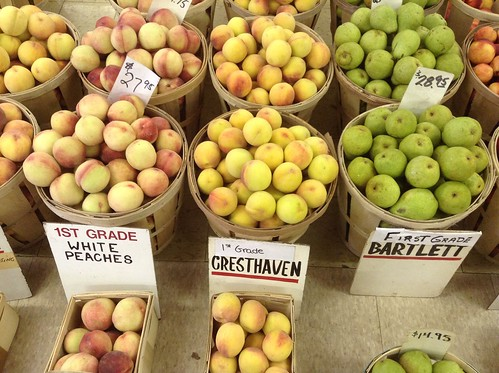

'peach/11884191104.jpg'

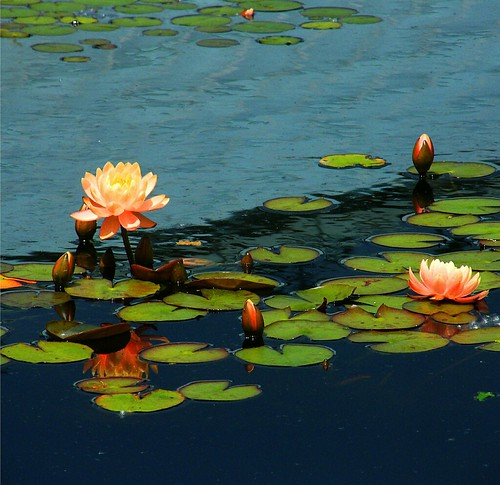

'peach/14440754038.jpg'

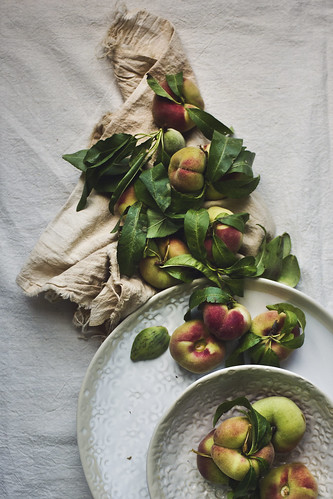

'peach/14475834903.jpg'

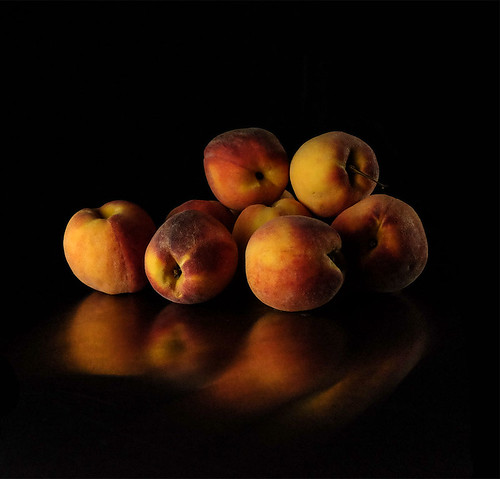

'peach/35928392304.jpg'

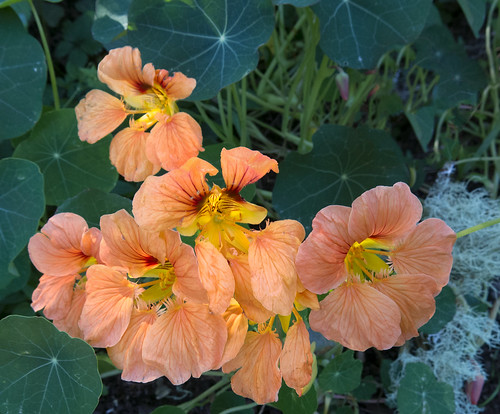

'peach/35362032041.jpg'

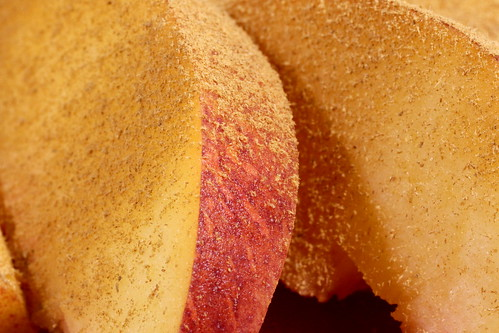

'peach/43209279700.jpg'

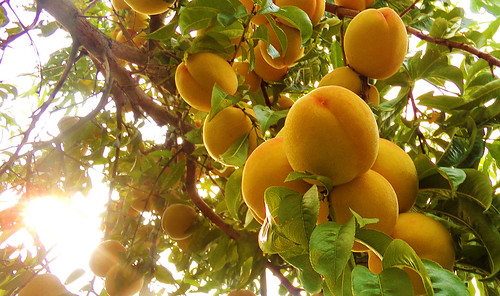

'peach/44140297222.jpg'

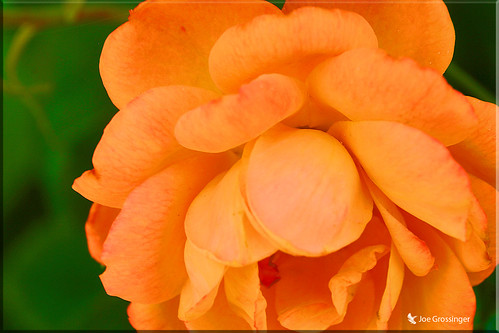

'peach/36198713545.jpg'

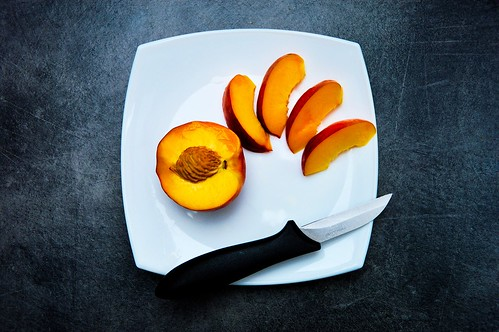

'peach/35370907650.jpg'

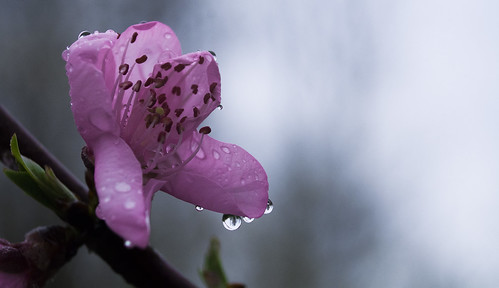

'peach/25015539852.jpg'

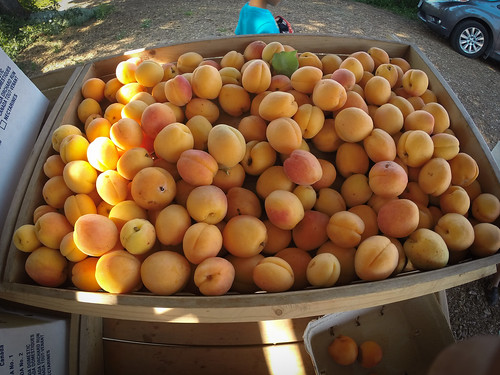

'peach/32850989162.jpg'

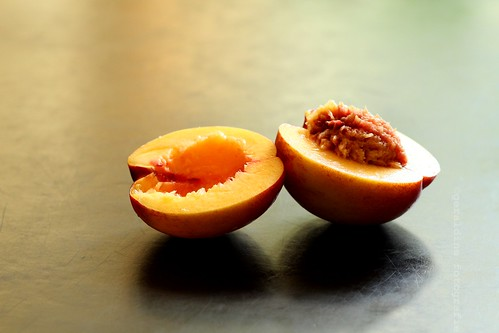

'peach/29135966763.jpg'

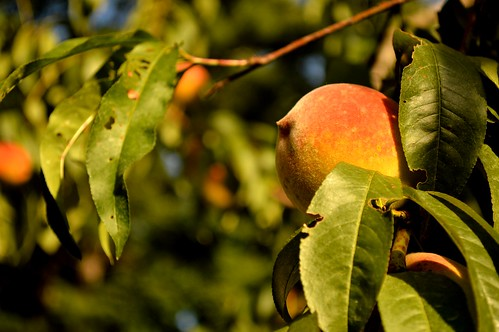

'peach/14777809780.jpg'

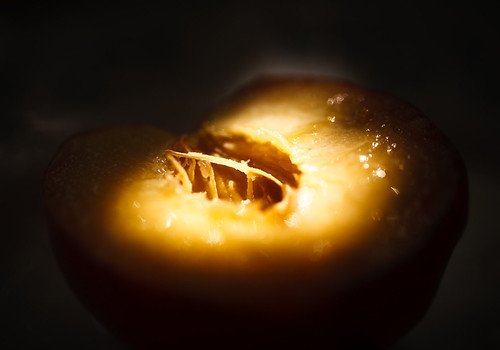

'peach/35480444253.jpg'

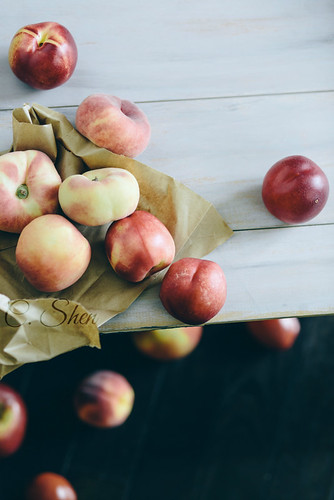

'peach/14526059673.jpg'

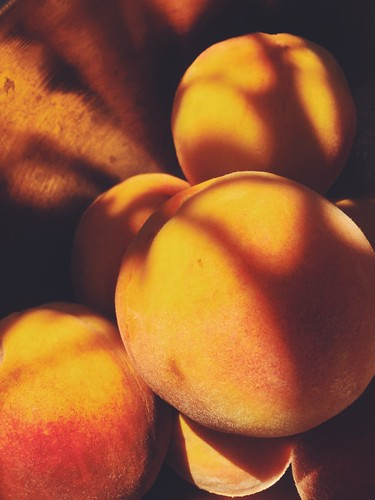

'peach/36173397514.jpg'

In [88]:
mm = {tuple(a): b for a, b in zip(p, glob('apple/*jpg') + glob('peach/*jpg'))}
wrong = [mm[tuple(a)] for a, p, t in zip(X_test, clf.predict(X_test), y_test) if p != t]

for x in wrong:
    display(Image(x, width=150),x)

In [52]:
1 - len(wrong)/len(X_test)

0.7358490566037736